# **Exploring the benefits of transfer learning while building brain tumour classifiers A comparative analysis of DL techniques** ⚖️

AI is huge. There are a lot of different models, parameters, and even subparameters to choose from. For image classification tasks, CNN-based models from scratch, and with transfer learning are currently the two most popular selections.

Transfer learning is a popular ML technique that applies previously learnt data onto a new dataset. Both models from scratch and transfer learning models can be used in image classification, and today we have applied these models in brain tumour classification tasks. When comparing these two models, transfer learning typically returns higher accuracies as transfer learning starts off with better initial results meaning they can be trained for less. Transfer learning models also achieve faster convergence as they already understand many features, and generalize well through the vast amount of data they have been previously trained on.

[This article](https://medium.com/@vinayasharmaa/machine-learning-madness-the-epic-battle-between-transfer-learning-and-models-from-scratch-for-51842945e895) will guide you through coding brain tumour classifiers, and if you want to learn more about the theory first, check out [this one](https://towardsdev.com/looking-at-the-world-through-the-eyes-of-a-computer-a2989527878c)! These will be 2 exciting builds in which you get to experience the benefits of transfer learning for yourself!

**Version 1 — Building a CNN from scratch** 👩‍💻


First things first, let’s import libraries. The backbones of our code:

numpy: python library for manipulating and computing mathematical functions on matrices

torch: library for PyTorch. We will be using Pytorch, a popular deep-learning framework for this build. Includes common DL mathematical functions.

matplotlib: python visualizations 📊

torchvision: PyTorch helper library for computer vision problems. Includes datasets, models, transformations etc…

os: manipulate data on our operating system ⚙️

In [1]:
import numpy as np 

import torch 
import matplotlib.pyplot as plt 
%matplotlib inline
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import pathlib
%config Completer.use_jedi = False

**Now let’s embrace our inner detectives — time to analyze and organize the data**

We will be using the Kaggle Brain Tumor Classification (MRI) dataset. This dataset contains 3264 files, is separated into train and test folders, and is further classified into 3 types of brain tumours: Glioma, Meningioma, and Pituitary.

All jpg’s need to be converted into tensors so that we can do some exciting math to extract a classification. We do this with transformations! We need all data to be the same dimensions, so I resize all images to 128x128 in order to save computational time. I also convert the images to grayscale, as grayscale data was producing better accuracies during model tests. 🌚

I have set 2 transformations, with the second adding some random auto contrast and colour jitters. This technique of data augmentation effectively doubles our data and adds variance, allowing our model to generalize better.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grab data 
test_path = "../input/brain-tumor-classification-mri/Testing"
train_path = "../input/brain-tumor-classification-mri/Training"

# transformations 
transforms1 = transforms.Compose(
[
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

transforms2 = transforms.Compose(
[
    transforms.RandomAutocontrast(),
    transforms.ColorJitter(),
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# download data 
train_data1 = datasets.ImageFolder(train_path, transform=transforms1)
train_data2 = datasets.ImageFolder(train_path, transform=transforms2)
test_data = datasets.ImageFolder(test_path, transform=transforms1)

image_datasets = torch.utils.data.ConcatDataset([train_data1, train_data2])
valid_data, train_data = torch.utils.data.random_split(image_datasets, [740, 5000])

# create data loaders 
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [3]:
print(len(train_data))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

5000


(32, 1, 128, 128)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


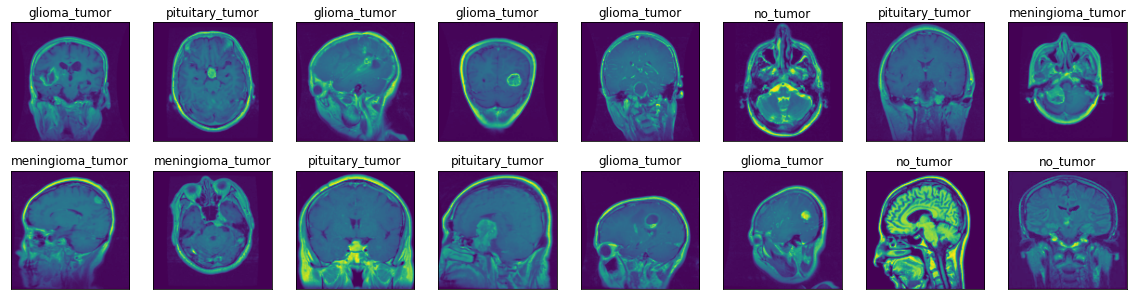

In [4]:
classes = test_loader.dataset.classes
print(classes)

# normalization function 
def imshow(im):
    plt.imshow(np.transpose(im, (1, 2, 0)))

# visualize data 
fig = plt.figure(figsize=(20,5))
for i in range (16):
    ax = fig.add_subplot(2, int(16/2), i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

**Coding the model** 🤩

The model architecture I have selected consists of 7 layers each containing a convolution, ReLU activation, 2D batch normalization and max pool. Followed by 4 fully connected layers each followed by a batch normalization.

**Once the model passes through multiple convolutional layers it is put through fully connected layers before predicting an output.**

The FC layers are a little more simple. Each neuron consists of weights and biases which are learnt during the training process to classify the features extracted during the first part of the network. These layers just need the input and output sizes as arguments.

In [5]:
# convolution network 
class conv_layer(nn.Module):
    def __init__(self, inp, out):
        super(conv_layer, self).__init__()
        self.conv1 = nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d(out)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self, x):
        x = self.pool(self.norm(self.relu(self.conv1(x))))
        return x
        
# model network 
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(1, affine=False)
        self.layer1 = conv_layer(inp=1, out=8)
        self.layer2 = conv_layer(inp=8, out=16)
        self.layer3 = conv_layer(inp=16, out=32)
        self.layer4 = conv_layer(inp=32, out=64)
        self.layer5 = conv_layer(inp=64, out=128)
        self.layer6 = conv_layer(inp=128, out=256)
        self.layer7 = conv_layer(inp=256, out=512)
        
        self.net = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6, self.layer7)
        
        self.fc1 = torch.nn.Linear(in_features=512, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=4)
        
        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  
        
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        return x

model = network()
sum([p.numel() for p in model.parameters()])

1646028

One of our final steps is defining our loss and optimizer functions. We will be using cross-entropy loss and the Adam optimizer from the torch library. Adam has become the go-to optimizer as it is straightforward, fast, requires less memory, and less tuning than other optimization algorithms. Adam finds the gradients of the cost and updates weights with varying learning rates. 🧮

If you want to learn more about the Adam optimizer check out this article, and to learn more about the functions discussed above, check out my previous article that goes in-depth on the theory of CNN architecture. 🤿

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0E-3)

In [7]:
epochs = 20 
min_loss = 100000

for i in range(epochs): 
    train_loss = 0 
    valid_loss = 0 
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        #back prop
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*labels.size(0)


    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*labels.size(0)
        
    total_train_loss = train_loss/len(train_loader)
    total_valid_loss = valid_loss/len(valid_loader)
    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(i, total_train_loss, total_valid_loss))
    if total_valid_loss < min_loss: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss
        
print("Congrats, training complete 🎉")


Epoch 0, 
training loss: 20.490889250093204 
validation loss: 17.75736305117607
loss decreased 100000 --> 17.75736305117607

Epoch 1, 
training loss: 9.811769433841583 
validation loss: 19.501856659849484

Epoch 2, 
training loss: 5.042537386250344 
validation loss: 29.815873384475708

Epoch 3, 
training loss: 3.1054890451917223 
validation loss: 11.578564157088598
loss decreased 17.75736305117607 --> 11.578564157088598

Epoch 4, 
training loss: 2.290586395248486 
validation loss: 6.567324711630742
loss decreased 11.578564157088598 --> 6.567324711630742

Epoch 5, 
training loss: 1.4131153827639902 
validation loss: 8.276169362167517

Epoch 6, 
training loss: 1.0620314173258034 
validation loss: 4.492905241437256
loss decreased 6.567324711630742 --> 4.492905241437256

Epoch 7, 
training loss: 1.0916982429802038 
validation loss: 3.3543932301302752
loss decreased 4.492905241437256 --> 3.3543932301302752

Epoch 8, 
training loss: 1.7384284986242367 
validation loss: 5.604527552922566

Ep

In [8]:
model.load_state_dict(torch.load("model.brain.pt"))

<All keys matched successfully>

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()
for images, labels in test_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(class_total, class_correct)

Test Loss: 0.059138

Test Accuracy of glioma_tumor: 20% (20/100)
Test Accuracy of meningioma_tumor: 97% (112/115)
Test Accuracy of no_tumor: 100% (105/105)
Test Accuracy of pituitary_tumor: 72% (54/74)

Test Accuracy (Overall): 73% (291/394)
[100.0, 115.0, 105.0, 74.0] [20.0, 112.0, 105.0, 54.0]


After training on a GPU for 20 epochs the model achieved more than 75% accuracy on the testing dataset. Considering this simple model was able to identify MRI scans without tumours with 100% accuracy provides tremendous hope for the medical imaging community. Imagine if doctors were able to utilize AI to help advise and efficiently classify scans in order to help patients in need. Not only would time be saved, but processes could be made cheaper and more accessible as well. 🌎 = 🙂

With Pytorch, building CNN models has become pretty simple. A lot of the mathematical work has been extracted for us. However, over the years new improvements have come to the ML community and we have a couple more options to test out to improve our accuracy. 

**Check out the transfer learning notebook to increase accuracies even further!**